## Goal: image classification using CNN with Transfer Learning

In [2]:
# Open google colab and to load the data present in your drive
from google.colab import drive
drive.mount('/content/drive')
# Have to give authorisation to your gmail account

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### - import necessary libraries

In [6]:
import os
import cv2 
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.applications import mobilenet_v2
from tensorflow.keras import preprocessing 
from tensorflow.keras.preprocessing import image

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# define the path of Parent folder containing all subfolder with images eg . '/content/drive/MyDrive/Images_PCA_Pasilla'
train_path = '/content/drive/MyDrive/Images_PCA_Pasilla/Fingers'

In [5]:
# ImageDataGenerator also has various data augmentation capabilities 
# to increase the datasets by performing various image augmentations like height/width shiting , zooming, shearing, flipping etc.

train_datagen = ImageDataGenerator(rescale=1.0/255.0,validation_split=0.2) 

# classes give in the subfolders that you like to classify, you can experiment with batch size since 
# it has direct impact to the RAM capacity to store the images in an array
train_batches = train_datagen.flow_from_directory(directory=train_path, \
target_size=(224,224), classes=['0', '1','2', '3'], batch_size=1106,subset='training')

validation_batches = train_datagen.flow_from_directory(directory=train_path, \
target_size=(224,224), classes=['0', '1','2', '3'], batch_size=1106,subset='validation')


Found 1106 images belonging to 4 classes.
Found 274 images belonging to 4 classes.


In [8]:
# load all train images at once
xtrain, ytrain = next(train_batches)
xtrain.shape, ytrain.shape

((1106, 224, 224, 3), (1106, 4))

In [ ]:
# load all validation images at once
x_val, y_val = next(validation_batches)
x_val.shape, y_val.shape

In [9]:
classes=['0', '1','2', '3']

In [11]:
base_model = mobilenet_v2.MobileNetV2(
    weights='imagenet', 
    alpha=0.35,         # specific parameter of this model, small alpha reduces the number of overall weights
    pooling='avg',      # applies global average pooling to the output of the last conv layer (like a flattening)
    include_top=False,  # !!!!! we only want to have the base, not the final dense layers 
    input_shape=(224, 224, 3)
)

2031616/2019640 [==============================] - 0s 0us/step


In [12]:
# freeze it!
base_model.trainable = False

In [13]:
model = keras.Sequential()
model.add(base_model)
model.add(keras.layers.Dense(100, activation='relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(len(classes), activation='softmax')) #!!! Final layer with a length of 2, and softmax activation 
# have a look at the trainable and non-trainable params statistic
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_0.35_224 (Funct  (None, 1280)             410208    
 ional)                                                          
                                                                 
 dense (Dense)               (None, 100)               128100    
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 404       
                                                                 
Total params: 538,712
Trainable params: 128,504
Non-trainable params: 410,208
_________________________________________________________________


In [14]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
              loss=keras.losses.categorical_crossentropy,
              metrics=[keras.metrics.categorical_accuracy])

# observe the validation loss and stop when it does not improve after 3 iterations
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

model.fit(xtrain, ytrain, 
          epochs=50, 
          verbose=2,
          batch_size=100, 
          callbacks=[callback],
          validation_split=0.0,
          validation_data=(x_val, y_val))

Epoch 1/50
9/9 - 15s - loss: 0.9520 - categorical_accuracy: 0.6007 - val_loss: 0.3998 - val_categorical_accuracy: 0.9279 - 15s/epoch - 2s/step
Epoch 2/50
9/9 - 1s - loss: 0.3949 - categorical_accuracy: 0.8756 - val_loss: 0.1935 - val_categorical_accuracy: 0.9820 - 1s/epoch - 142ms/step
Epoch 3/50
9/9 - 1s - loss: 0.2246 - categorical_accuracy: 0.9367 - val_loss: 0.1175 - val_categorical_accuracy: 0.9865 - 1s/epoch - 147ms/step
Epoch 4/50
9/9 - 1s - loss: 0.1538 - categorical_accuracy: 0.9593 - val_loss: 0.0867 - val_categorical_accuracy: 0.9910 - 1s/epoch - 142ms/step
Epoch 5/50
9/9 - 1s - loss: 0.1085 - categorical_accuracy: 0.9740 - val_loss: 0.0700 - val_categorical_accuracy: 0.9955 - 1s/epoch - 142ms/step
Epoch 6/50
9/9 - 1s - loss: 0.0909 - categorical_accuracy: 0.9695 - val_loss: 0.0642 - val_categorical_accuracy: 0.9865 - 1s/epoch - 146ms/step
Epoch 7/50
9/9 - 1s - loss: 0.0801 - categorical_accuracy: 0.9785 - val_loss: 0.0589 - val_categorical_accuracy: 0.9910 - 1s/epoch - 143m

#### - Predicition

+ Test on Fist

In [16]:
img = plt.imread('/content/drive/MyDrive/Images_PCA_Pasilla/fist/20-55-23-991225.png')

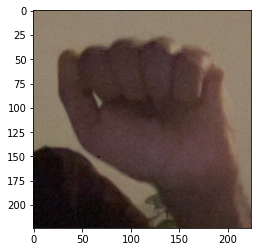

In [17]:
plt.imshow(img)

In [24]:
a = image.img_to_array(img, dtype = 'uint8')
a.shape

(224, 224, 3)

In [25]:
import numpy as np
a = np.expand_dims(a, axis=0)
a.shape

(1, 224, 224, 3)

In [26]:
model.predict(a)

array([[0.95558566, 0.00348968, 0.00606875, 0.03485595]], dtype=float32)

In [27]:
model.predict(a)[0].round(decimals = 3)

array([0.956, 0.003, 0.006, 0.035], dtype=float32)

<BarContainer object of 4 artists>

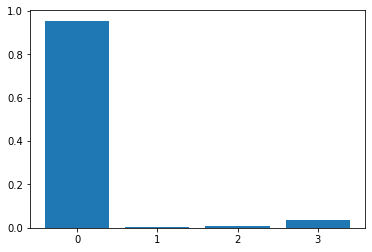

In [28]:
plt.bar(x = classes, height = model.predict(a)[0])

+ test on Hello

In [29]:
img_hello = plt.imread('/content/drive/MyDrive/Images_PCA_Pasilla/hello/davis_13-33-22-143203.png')

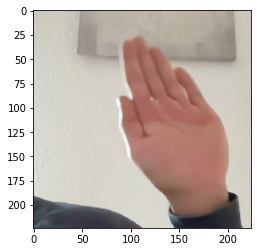

In [30]:
plt.imshow(img_hello)

In [31]:
b = image.img_to_array(img_hello, dtype = 'uint8')
b = np.expand_dims(b, axis=0)
b.shape

(1, 224, 224, 3)

In [32]:
model.predict(b)

array([[0.95558566, 0.00348968, 0.00606875, 0.03485595]], dtype=float32)

<BarContainer object of 4 artists>

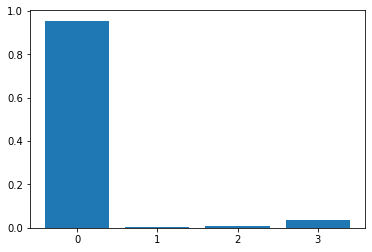

In [33]:
plt.bar(x = classes, height = model.predict(b)[0])

+ test on One Finger

In [34]:
img_one = plt.imread('/content/drive/MyDrive/Images_PCA_Pasilla/one_finger/20-53-54-563349.png')

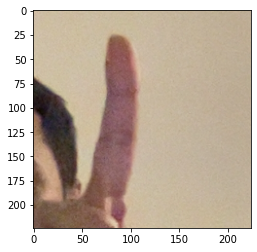

In [35]:
plt.imshow(img_one)

In [36]:
c = image.img_to_array(img_one, dtype = 'uint8')
c = np.expand_dims(c, axis=0)
c.shape

(1, 224, 224, 3)

In [37]:
model.predict(c)

array([[0.95558566, 0.00348968, 0.00606875, 0.03485595]], dtype=float32)

<BarContainer object of 4 artists>

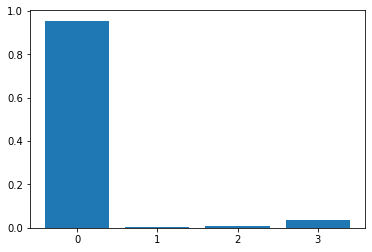

In [38]:
plt.bar(x = classes, height = model.predict(c)[0])

+ test on Two fingers

In [39]:
img_two = plt.imread('/content/drive/MyDrive/Images_PCA_Pasilla/two_fingers/20-21-19-329594.png')

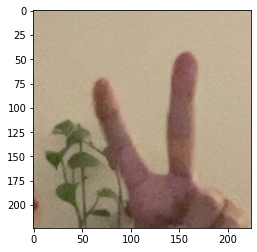

In [40]:
plt.imshow(img_two)

In [41]:
d = image.img_to_array(img_two, dtype = 'uint8')
d = np.expand_dims(d, axis=0)
d.shape

(1, 224, 224, 3)

In [42]:
model.predict(d)

array([[0.95558566, 0.00348968, 0.00606875, 0.03485595]], dtype=float32)

<BarContainer object of 4 artists>

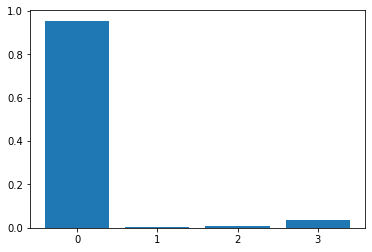

In [43]:
plt.bar(x = classes, height = model.predict(d)[0])